In [1]:
#export
from exp.nb_nb03 import *
from scipy.fftpack import dct

In [2]:
#export
import librosa.display

In [3]:
import librosa

### Load audio

In [4]:
path = './P066201.wav'

In [7]:
y, sr = load_audio(path)

In [8]:
librosa.effects.split(y,top_db=20)

array([[ 1024, 11776],
       [18432, 32768],
       [38400, 48640]])

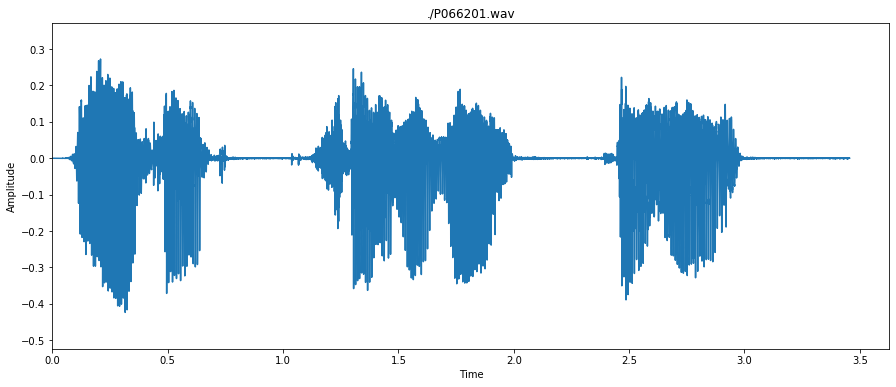

In [9]:
plot_signal(y, sr, title=path)

### Frequency domain features
\begin{enumerate}
\item STFT
\item MFCC
\item LPCC
\end{enumerate}

#### STFT

<img src='../images/narrow wide band spec.png'/>

In [10]:
#export
def stft (frames, NFFT = None):
    if not NFFT:
        NFFT = len(frames[0])
    return np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT

In [11]:
stft(pre_process(y,sr)).shape

(344, 201)

Text(0.5, 1.0, 'Linear-frequency power wideband-spectrogram')

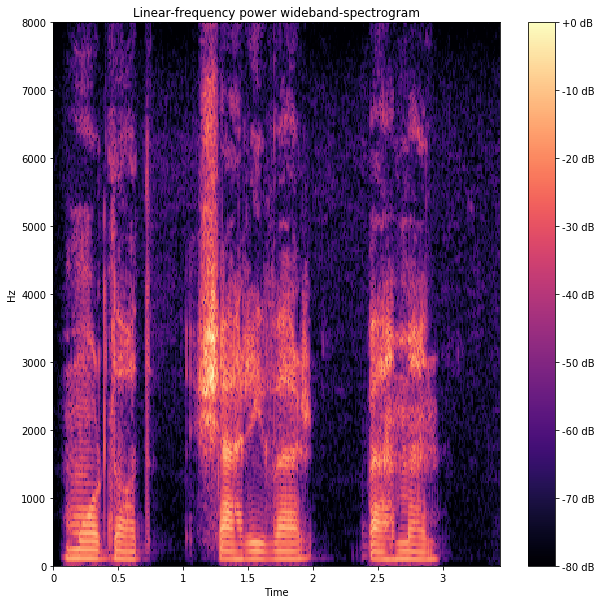

In [10]:
D = librosa.amplitude_to_db(stft(pre_process(y,sr)), ref=np.max)
# plt.subplot(4, 2, 1)
plt.figure(figsize=(10,10))
librosa.display.specshow(D.T, y_axis='linear',x_axis = 'time', sr = sr,hop_length=int(sr*0.01) )
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power wideband-spectrogram')

Text(0.5, 1.0, 'Linear-frequency power Narrowband-spectrogram')

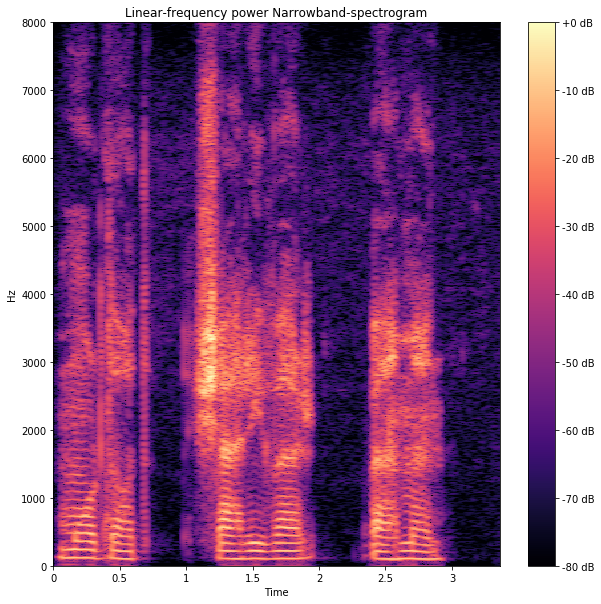

In [12]:
D = librosa.amplitude_to_db(stft(pre_process(y,sr,frame_length=0.1)), ref=np.max)
plt.figure(figsize=(10,10))
librosa.display.specshow(D.T, y_axis='linear',x_axis = 'time', sr = sr,hop_length=int(sr*0.01) )
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power Narrowband-spectrogram')

##### Pitch-shifting

Text(0.5, 1.0, 'Linear-frequency power 0-1000Hz')

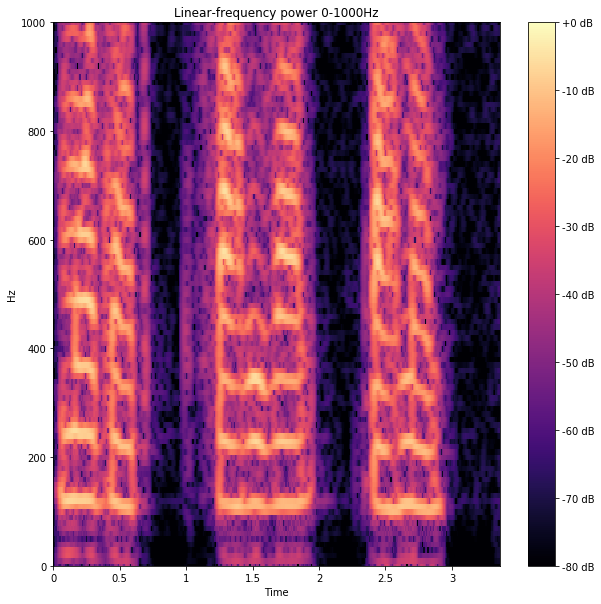

In [13]:
D = librosa.amplitude_to_db(stft(pre_process(y,sr,frame_length=0.1)), ref=np.max)
plt.figure(figsize=(10,10))
librosa.display.specshow(D.T, y_axis='linear',x_axis = 'time', sr = sr,hop_length=int(sr*0.01) )
plt.colorbar(format='%+2.0f dB')
plt.ylim((0,1000))
plt.title('Linear-frequency power 0-1000Hz')

In [12]:
shift = -2

##### linrosa pitch shift

In [13]:
y, sr

(array([3.0517578e-05, 3.0517578e-05, 3.0517578e-05, ..., 7.3242188e-04,
        8.2397461e-04, 5.4931641e-04], dtype=float32), 16000)

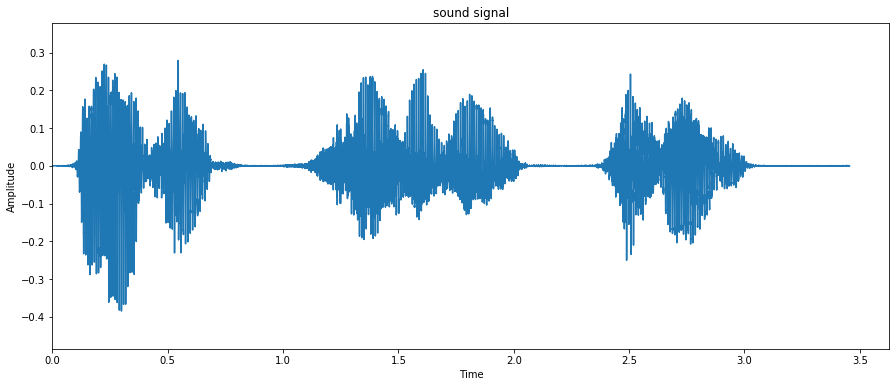

In [14]:
y_shift = librosa.effects.pitch_shift(y, sr, n_steps=shift)
plot_signal(y_shift,sr)

Text(0.5, 1.0, 'Linear-frequency power 0-1000Hz')

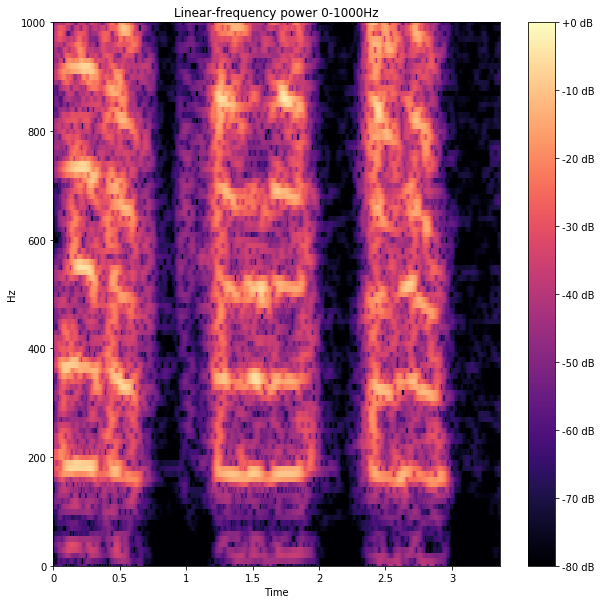

In [17]:
D = librosa.amplitude_to_db(stft(pre_process(y_shift,sr,frame_length=0.1)), ref=np.max)
plt.figure(figsize=(10,10))
librosa.display.specshow(D.T, y_axis='linear',x_axis = 'time', sr = sr,hop_length=int(sr*0.01) )
plt.colorbar(format='%+2.0f dB')
plt.ylim((0,1000))
plt.title('Linear-frequency power 0-1000Hz')

#### MFCC


<img src='../images/mfcc plot.png'/>

Steps:


\begin{enumerate}
\item Preprocess
\item Take the Discrete Fourier Transform (DFT) of the frame
\item Compute the Mel-spaced filterbank. This is a set of 20-40 (26 is standard) triangular filters that we apply to the periodogram power spectral estimate from step 2
\item Take the log of each of the 26 energies from step 3. This leaves us with 26 log filterbank energies.
\item Take the Discrete Cosine Transform (DCT) of the 26 log filterbank energies to give 26 cepstral coefficents.
\end{enumerate}


<img src='../images/Block-diagram-of-MFCC.png'/>



#### Compute the Mel-spaced filterbank

The formula for converting from frequency to Mel scale is:
\begin{equation}
M(f) = 1125 \ln{(\frac{1+f}{700})}
\end{equation}

To go from Mels back to frequency:
\begin{equation}
M^{-1}(m) = 700(\exp{(\frac{m}{1125})^{-1})}
\end{equation}

In [18]:
#export
def mel_filter_bank(nfilt= 40, NFFT =512,sr = 16000):
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sr / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bins = np.floor(NFFT * hz_points / sr)
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bins[m - 1])   # left
        f_m = int(bins[m])             # center
        f_m_plus = int(bins[m + 1])    # right
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bins[m - 1]) / (bins[m] - bins[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bins[m + 1] - k) / (bins[m + 1] - bins[m])
    return fbank

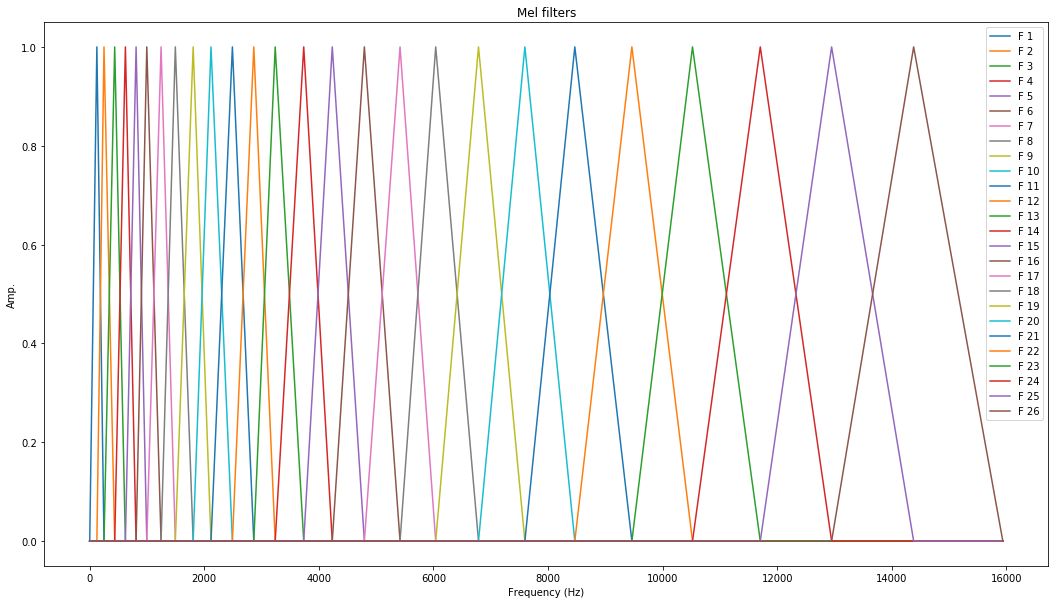

In [19]:
fbank = mel_filter_bank(26)
plt.figure(figsize=(18,10))
for i,bank in enumerate(fbank):
    plt.plot(np.arange(len(bank))*(sr/len(bank)),bank, label = f'F {i+1}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amp.')
plt.title('Mel filters')
plt.legend()

In [22]:
#export
def mfcc(frames, nceps = 13, nfilt = 40, sr=16000, mean_normaliation = False, plot = False, stride = None):
    NFFT = len(frames[0])
    mag_frames = stft(frames, NFFT)
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum
    fbank = mel_filter_bank(nfilt, NFFT, sr)
    result = np.dot(pow_frames, fbank.T)
    stable_result = np.where(result == 0, np.finfo(float).eps, result)  # Numerical Stability
    stable_result_db = 20 * np.log10(stable_result)  # dB
    if mean_normaliation:
        stable_result_db -= (np.mean(stable_result_db, axis=0) + 1e-8)
    if plot:
        plt.figure(figsize=(10,10))
        librosa.display.specshow(stable_result_db.T, y_axis='linear',x_axis = 'time', sr = sr,hop_length=stride )
        plt.colorbar(format='%+2.0f dB')
        plt.title('Linear-frequency power Narrowband-spectrogram')
        plt.show()
    mfcc = dct(stable_result_db, type=2, axis=1, norm='ortho')[:, 1 : (nceps + 1)]
    return mfcc

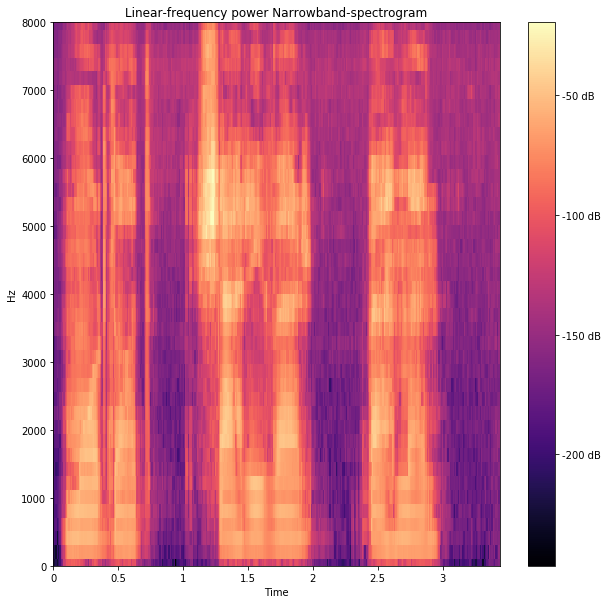

(344, 13)

In [23]:
mfcc(pre_process(y,sr,frame_length=0.025),plot = True, stride = int(0.01*sr)).shape

\begin{equation}
d_t = \frac {\sum_{n=1}^{N} n(c_{t+n}-c_{t-n})}{2\sum_{n=1}^{N}n^2}
\end{equation}


In [24]:
#export
def delta(feat, N =2):
    if N < 1:
        raise ValueError('N must be an integer >= 1')
    NUMFRAMES = len(feat)
    denominator = 2 * sum([i**2 for i in range(1, N+1)])
    delta_feat = np.empty_like(feat)
    padded = np.pad(feat, ((N, N), (0, 0)), mode='edge')   # padded version of feat
    for t in range(NUMFRAMES):
        delta_feat[t] = np.dot(np.arange(-N, N+1), padded[t : t+2*N+1]) / denominator   # [t : t+2*N+1] == [(N+t)-N : (N+t)+N+1]
    return delta_feat

In [25]:
delta(mfcc(pre_process(y,sr,frame_length=0.025), stride = int(0.01*sr))).shape

(344, 13)

### Vocal System

<img src='../images/vocal system.png'/>

### Auditory System

<img src='../images/auditory system.png'/>

In [ ]:
!python3 ../notebook2script.py ./nb04_frequency_domain_features.ipynb